In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import glob
import re
import time
import seaborn as sns
import xgboost as xgb
import csv
import pickle
color = sns.color_palette()

/kaggle/dev/ashish/sberbank-russian-housing-market/sber/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
DATA_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/'
RAW_DATA_PATH = DATA_PATH + 'raw_data/'
PRE_PROCESSED_DATA_PATH = DATA_PATH + 'pre_processed_data/'
TRAIN_DATA = PRE_PROCESSED_DATA_PATH + 'train_pre_processed_1495598960.csv'
TEST_DATA = PRE_PROCESSED_DATA_PATH + 'test_pre_processed_1495598960.csv'
MACRO_DATA = PRE_PROCESSED_DATA_PATH + 'macro_pre_processed_1495598960.csv'
MODELS_PATH = '/kaggle/dev/ashish/sberbank-russian-housing-market/models/'
SUBMISSIONS_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/submissions/'

In [13]:
# Prep
train_df = pd.read_csv(TRAIN_DATA, parse_dates=['timestamp'])
macro_df = pd.read_csv(MACRO_DATA, parse_dates=['timestamp'])
test_df = pd.read_csv(TEST_DATA, parse_dates=['timestamp'])

print('Train data', train_df.shape)
print('Test data', test_df.shape)
print('Macro data', macro_df.shape)

Train data (30471, 295)
Test data (7662, 294)
Macro data (2484, 100)


In [14]:
print(train_df['timestamp'].dtype)

datetime64[ns]


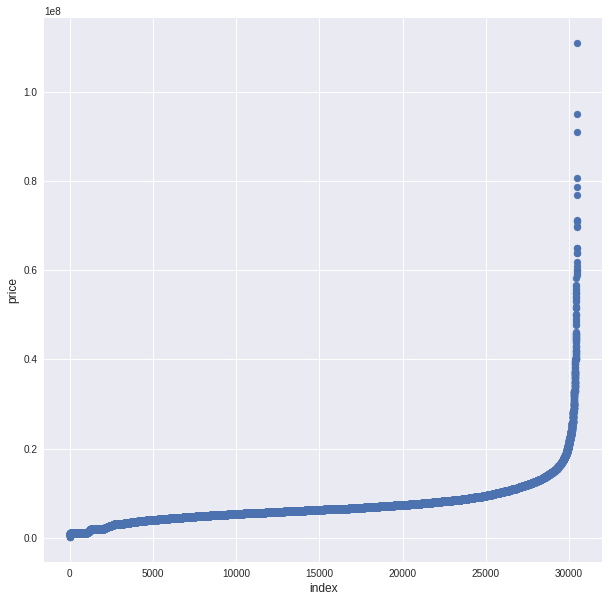

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

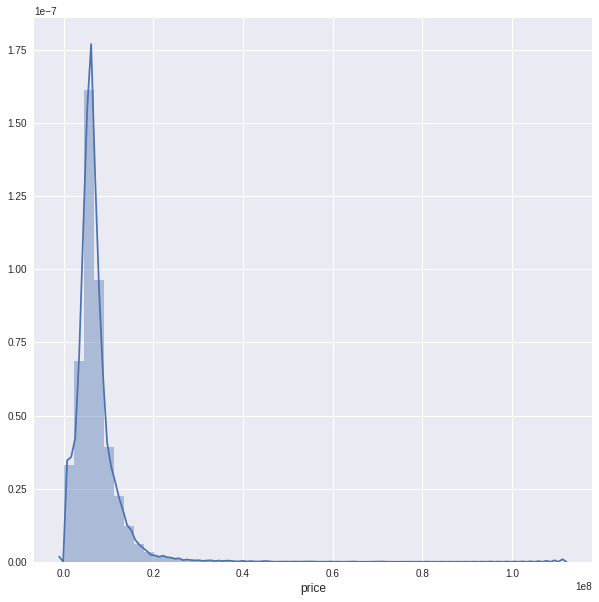

In [16]:
plt.figure(figsize=(10,10))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

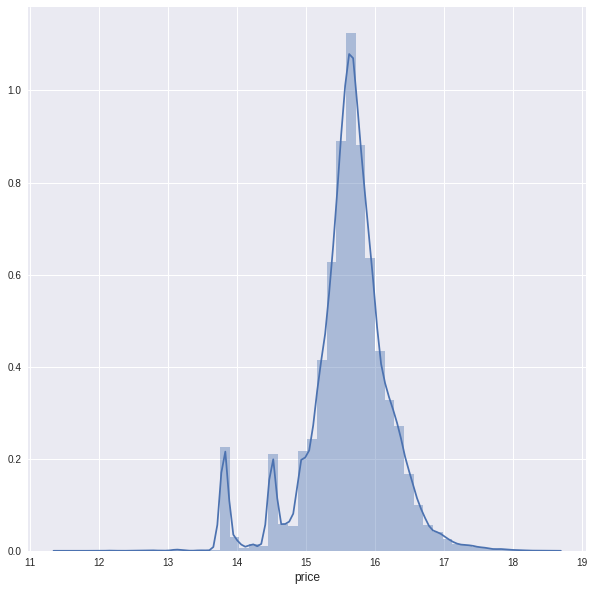

In [18]:
plt.figure(figsize=(10,10))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [ ]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4] + x[5:7])
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=16)
plt.xlabel('Year Month', fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

In [24]:
print('Merging with macro data..')
# Merge train/test data with macro data
train_macro_df =  pd.merge(train_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(train_macro_df) == len(train_df))
test_macro_df =  pd.merge(test_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(test_macro_df) == len(test_df))

print('Train + Macro data', train_macro_df.shape)
print('Test + Macro data', test_macro_df.shape)

Merging with macro data..
Train + Macro data (30471, 394)
Test + Macro data (7662, 393)


In [27]:
missing_df = train_macro_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(['column_name'], ascending=[True])
missing_df

,column_name,missing_count


In [ ]:
ind = np.arange(missing_df.shape[0])
plt.figure(figsize=(12,18))
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
plt.show()

In [20]:
train_macro_df =  pd.merge(train_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(train_macro_df) == len(train_df))

In [21]:
test_macro_df =  pd.merge(test_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(test_macro_df) == len(test_df))

In [267]:
# Skip merging with macro data
train_macro_df = train_df
test_macro_df = test_df

In [270]:
for i in train_macro_df.columns:
    try:
        if not(train_macro_df[i].dtype == test_macro_df[i].dtype):
            print('train:', i, '-', train_macro_df[i].dtype, '; test:', i, '-', test_macro_df[i].dtype)
    except KeyError:
        print('KeyError- skipping for:', i)

KeyError- skipping for: price_doc


In [269]:
train_macro_df['full_sq'] = train_macro_df['full_sq'].astype('float64')
test_macro_df['floor'] = test_macro_df['floor'].astype('float64')
test_macro_df['max_floor'] = test_macro_df['max_floor'].astype('float64')
test_macro_df['material'] = test_macro_df['material'].astype('float64')
test_macro_df['num_room'] = test_macro_df['num_room'].astype('float64')

In [271]:
def kinetic_energy(column_df):
    probs=(np.unique(column_df, return_counts=True)[1]).astype(float)/column_df.shape[0]
    kinetic=np.sum(probs**2)
    return kinetic

def replace_nan(column_df):
    #droping   rows from column df in order to compute  kinetic  for  existing  categories
    feature_without_nans=column_df.dropna(axis=0,inplace=False)
    kinetic_replace_value=kinetic_energy(feature_without_nans)
    column_df=column_df.fillna(value=kinetic_replace_value)
    return column_df

for col in train_macro_df.columns:
    if train_macro_df[col].isnull().values.any()==True:
        train_macro_df[col]=replace_nan(train_macro_df[col])

train_macro_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43.0,27.0,4.0,0.10838,0.493169,0.01998,0.334164,0.126191,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34.0,19.0,3.0,0.10838,0.493169,0.01998,0.334164,0.126191,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43.0,29.0,2.0,0.10838,0.493169,0.01998,0.334164,0.126191,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89.0,50.0,9.0,0.10838,0.493169,0.01998,0.334164,0.126191,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77.0,77.0,4.0,0.10838,0.493169,0.01998,0.334164,0.126191,...,319,108,17,135,236,2,91,195,14,16331452


In [272]:
for col in test_macro_df.columns:
    if test_macro_df[col].isnull().values.any()==True:
        test_macro_df[col]=replace_nan(test_macro_df[col])

test_macro_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.700000,2.0,9.0,1.0,1998.0,1.0,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,0.006601,8.0,17.0,1.0,0.0,3.0,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.100000,3.0,5.0,2.0,1960.0,2.0,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.000000,17.0,17.0,1.0,2016.0,2.0,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.000000,17.0,17.0,1.0,0.0,1.0,1.0,...,5,1,1,0,2,12,0,1,11,1


In [273]:
train_columns = set(train_macro_df.columns)
drop_columns = ['id', 'timestamp', 'price_doc', 'child_on_acc_pre_school']

for col in drop_columns:
    if col in train_columns:
        train_columns.remove(col)

for f in train_columns:
    if train_macro_df[f].dtype=='object':
        print('encoding column:', f, '(original dtype:', train_macro_df[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(train_macro_df[f].values) | set(test_macro_df[f].values)))
        try:
            train_macro_df[f] = lbl.transform(list(train_macro_df[f].values))
            test_macro_df[f] = lbl.transform(list(test_macro_df[f].values))
        except TypeError as err:
            print(f)
            print(err)

train_macro_df.to_csv(DATA_PATH + 'train_preprocessed.csv')
test_macro_df.to_csv(DATA_PATH + 'test_preprocessed.csv')

encoding column: water_1line (original dtype: object )
encoding column: ecology (original dtype: object )
encoding column: thermal_power_plant_raion (original dtype: object )
encoding column: radiation_raion (original dtype: object )
encoding column: nuclear_reactor_raion (original dtype: object )
encoding column: sub_area (original dtype: object )
encoding column: detention_facility_raion (original dtype: object )
encoding column: incineration_raion (original dtype: object )
encoding column: railroad_1line (original dtype: object )
encoding column: culture_objects_top_25 (original dtype: object )
encoding column: product_type (original dtype: object )
encoding column: oil_chemistry_raion (original dtype: object )
encoding column: big_road1_1line (original dtype: object )
encoding column: big_market_raion (original dtype: object )
encoding column: railroad_terminal_raion (original dtype: object )


In [274]:
train_df = pd.read_csv(DATA_PATH + 'train_preprocessed.csv')
test_df = pd.read_csv(DATA_PATH + 'test_preprocessed.csv')
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

train_df.shape (30471, 293)
test_df.shape (7662, 292)


In [278]:
def rmsle(y_predicted, y_true):
    y_pred = y_predicted
    y_label = y_true.get_label()
    temp = np.square(np.log(y_pred + 1.0) - np.log(y_label + 1.0))
    error = np.sqrt(np.mean(temp))
    error_std = np.sqrt(np.std(temp))
    print('rmsle:', error, '; std:', error_std)
    return ("", error)

X = train_df[list(train_columns)]
Y = train_df.price_doc.values

train_X, val_X, train_Y, val_Y = model_selection.train_test_split(X, Y, train_size=0.7, random_state=42)

print('train_X.shape', train_X.shape)
print('train_Y.shape', train_Y.shape)
print('val_X.shape', val_X.shape)
print('val_Y.shape', val_Y.shape)

train_X.shape (21329, 289)
train_Y.shape (21329,)
val_X.shape (9142, 289)
val_Y.shape (9142,)


In [279]:
model = xgb.XGBRegressor(max_depth=8,
                        #gamma=0.5,
                        objective="reg:linear",
                        n_estimators=1000,
                        #min_child_weight=6,
                        learning_rate=0.05,
                        nthread=12,
                        subsample=0.70,
                        colsample_bytree=0.70,
                        seed=42,
                        #max_delta_step=1,
                        reg_alpha=0.5,
                        reg_lambda=0.5)

model.fit(train_X, train_Y, eval_set=[(val_X, val_Y)], verbose=True, eval_metric=rmsle, early_stopping_rounds=50)

model_id = "model-" + str(int(time.time()))
pickle.dump(model, open(MODELS_PATH + model_id + ".xgb", "wb"))

print("Saved model ", model_id)

rmsle: 2.96201 ; std: 1.60538
[0]	validation_0-:2.96201
Will train until validation_0- hasn't improved in 50 rounds.
rmsle: 2.29809 ; std: 1.29669
[1]	validation_0-:2.29809
rmsle: 1.9262 ; std: 1.12769
[2]	validation_0-:1.9262
rmsle: 1.67214 ; std: 1.00875
[3]	validation_0-:1.67214
rmsle: 1.47854 ; std: 0.916848
[4]	validation_0-:1.47854
rmsle: 1.33054 ; std: 0.838093
[5]	validation_0-:1.33054
rmsle: 1.21063 ; std: 0.774983
[6]	validation_0-:1.21063
rmsle: 1.10978 ; std: 0.726268
[7]	validation_0-:1.10978
rmsle: 1.02512 ; std: 0.687774
[8]	validation_0-:1.02512
rmsle: 0.952843 ; std: 0.660144
[9]	validation_0-:0.952843
rmsle: 0.8907 ; std: 0.642344
[10]	validation_0-:0.8907
rmsle: 0.836977 ; std: 0.629651
[11]	validation_0-:0.836977
rmsle: 0.790302 ; std: 0.627133
[12]	validation_0-:0.790302
rmsle: 0.749788 ; std: 0.627969
[13]	validation_0-:0.749788
rmsle: 0.713234 ; std: 0.634129
[14]	validation_0-:0.713234
rmsle: 0.682276 ; std: 0.642974
[15]	validation_0-:0.682276
rmsle: 0.654808 ;

In [16]:
train_X

array([[46, nan, 4.0, ..., 0, 6, 1],
       [134, nan, 2.0, ..., 0, 0, 0],
       [44, 28.0, 6.0, ..., 8, 82, 12],
       ..., 
       [59, 41.0, 4.0, ..., 7, 44, 7],
       [64, 33.0, 2.0, ..., 0, 6, 1],
       [33, 13.0, 15.0, ..., 0, 13, 1]], dtype=object)

In [239]:
test_columns = list(train_columns)
test_columns.append('id')

test_X =  test_df[test_columns]
print(test_X.shape)

(7662, 388)


In [240]:
model = pickle.load(open(MODELS_PATH + 'model-1495097956.xgb', 'rb'))
filename = SUBMISSIONS_PATH + 'submission-' + str(int(time.time())) + ".csv"
test_X['predicted_price_doc'] = model.predict(test_X.loc[:, train_columns])
predicted_submission_df = test_X[['id', 'predicted_price_doc']]
predicted_submission_df.columns = ['id', 'price_doc']
predicted_submission_df.to_csv(filename, index=False)
print('Generated submission file: {}'.format(filename))

Generated submission file: /kaggle/dev/sberbank-russian-housing-market-data/submissions/submission-1495097995.csv


/kaggle/dev/ashish/sberbank-russian-housing-market/sber/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
